# Rotating harmonic oscillator entropy tests

This notebook tests the entropy production rate for a Brownian particle in a harmonic trap subject to a non-conservative, rotating force. Specifically, the bead is described by the Langevin equation:

$$\gamma \dfrac{d \vec{r}}{dt} = -k \vec{r} + \alpha \left( \hat{z} \times \vec{r} \right) + \vec{\xi}$$

Broken into components, it is

$$\gamma \dot{x} = -kx - \alpha y + \xi_x$$
$$\gamma \dot{y} = -ky + \alpha x + \xi_y$$

where $\vec{\xi}$ is zero-mean Gaussian white noise, i.e. $\langle \xi_i\rangle = 0$ and $\langle \xi_i(t) \xi_j(\tau) \rangle = 2D\gamma^2\delta_{ij} \delta(t-\tau)$. $\gamma$ is the drag on the particle, and $D$ is the diffusion constant defined by the Einstein relation, $D = k_B T/\gamma$.

The analytic entropy production rate is given by

$$\dfrac{dS}{dt} = \dfrac{2 \alpha^2}{k}$$

The simulation is implemented by the `spinOscLangevin` class found in this folder.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from spinOscSimulation import spinOscLangevin
import freqent.freqent as fe
%matplotlib notebook

In [3]:
# Simulation environment parameters
gamma = 2e-8  # drag on 1um particle in water in kg/s
dt = 1e-3  # time step of simulation in seconds
nsteps = 1e4  # number of simulation steps
kT = 4e-9  # thermal energy in kg um^2 / s^2
r0 = np.random.rand(2)-0.5  # starting xy position in um

# create object
r = spinOscLangevin(dt=dt, nsteps=nsteps, kT=kT, gamma=gamma, r0=r0)

## Diffusivity test

First let's just check to make sure that the simulation gives valid diffusive behavior. We run the simulation with the potential turned off and measure the mean square displacement. The theoretical value expected is:

$$\langle (r(t+\tau) - r(t))^2\rangle = 4 D \tau$$

In [30]:
import pandas as pd
import trackpy as tp

# Calculate mean square displacement using trackpy's built-in function
mpp = 1  # microns/pixel, i.e. how many um is "1" in r.pos?
fps = int(1/r.dt)  # frames per second
max_lagtime = 1000  # max number of frames to calculate lagtime
all_data = pd.DataFrame(columns=['t', 'x', 'y', 'frame', 'particle'])
for ii in range(50):
    r.runSimulation(k=0, alpha=0)
    # First have to put data into a DataFrame
    data = pd.DataFrame({'t': r.t,
                         'x': r.pos[0],
                         'y': r.pos[1],
                         'frame': np.arange(len(r.t)),
                         'particle': ii * np.ones(len(r.t))})
    all_data = all_data.append(data)

/home/daniel/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


<IPython.core.display.Javascript object>


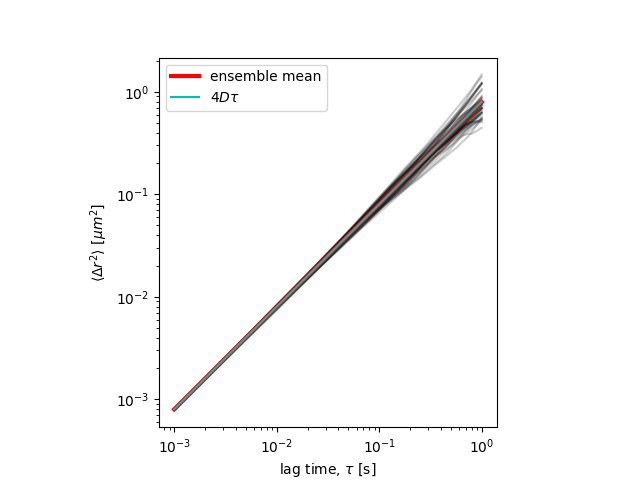

In [94]:
# msd for each simulation
msdInd = tp.imsd(all_data, mpp, fps, max_lagtime=max_lagtime)

# ensemble mean across all particles
msd = tp.emsd(all_data, mpp, fps, max_lagtime=max_lagtime)

# theoretical answer is 4Dt
thry = 4 * r.D * r.t[:max_lagtime]

fig, ax =plt.subplots()
ax.loglog(msdInd.index, msdInd, 'k-', alpha=0.2)
ax.loglog(msd.index, msd, 'r-', linewidth=3, label='ensemble mean')
ax.loglog(r.t[:max_lagtime], thry, 'c-', label=r'$4 D \tau$')
ax.set(xlabel=r'lag time, $\tau$ [s]',
       ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu m^2$]')
ax.set_aspect('equal')
plt.legend()

## Harmonic trap test

Now we calculate the correlation function for a particle trapped in a harmonic potential only. This should lead to a correlation function given by

$$\langle r_\mu(t) r_\nu(t + \tau) \rangle = \delta_{\mu \nu} \dfrac{D\gamma}{k} e^{-k |\tau|/\gamma}$$

In [90]:
# forcing parameters
k = 2 * r.gamma  # spring
r.reset()
nsim = 50
c_all = np.zeros((2, 2, int(2*nsteps + 1), nsim))

for ii in range(nsim):
    r.runSimulation(k=k, alpha=0)
    c_all[..., ii], tau = fe.corr_matrix(r.pos,
                                         sample_spacing=r.dt,
                                         mode='full',
                                         method='auto',
                                         return_fft=False)
    

/home/daniel/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/home/daniel/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


<IPython.core.display.Javascript object>


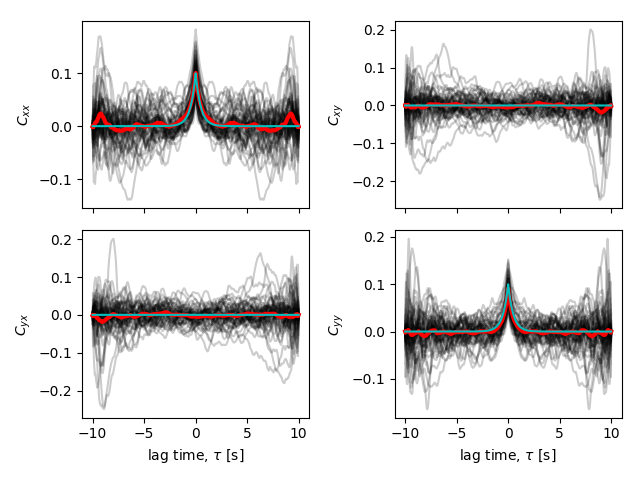

In [95]:
fig, ax = plt.subplots(2,2, sharex=True)

c_thry = np.zeros((2,2,int(2*nsteps + 1)))

c_thry[0, 0, :] = np.exp(-k * np.abs(tau) / r.gamma) * r.D * r.gamma / k
c_thry[1, 1, :] = c_thry[0, 0, :]

for ii in range(nsim):
    ax[0, 0].plot(tau, c_all[0, 0, :, ii], 'k-', alpha=0.2)
    ax[0, 1].plot(tau, c_all[0, 1, :, ii], 'k-', alpha=0.2)
    ax[1, 0].plot(tau, c_all[1, 0, :, ii], 'k-', alpha=0.2)
    ax[1, 1].plot(tau, c_all[1, 1, :, ii], 'k-', alpha=0.2)

ax[0, 0].plot(tau, np.mean(c_all[0, 0, :, :], axis=-1), 'r-', linewidth=3)
ax[0, 1].plot(tau, np.mean(c_all[0, 1, :, :], axis=-1), 'r-', linewidth=3)
ax[1, 0].plot(tau, np.mean(c_all[1, 0, :, :], axis=-1), 'r-', linewidth=3)
ax[1, 1].plot(tau, np.mean(c_all[1, 1, :, :], axis=-1), 'r-', linewidth=3)

ax[0, 0].plot(tau, c_thry[0, 0, :], 'c-')
ax[0, 1].plot(tau, c_thry[0, 1, :], 'c-')
ax[1, 0].plot(tau, c_thry[1, 0, :], 'c-')
ax[1, 1].plot(tau, c_thry[1, 1, :], 'c-')

ax[0, 0].set(ylabel=r'$C_{xx}$')
ax[0, 1].set(ylabel=r'$C_{xy}$')
ax[1, 0].set(xlabel=r'lag time, $\tau$ [s]', ylabel=r'$C_{yx}$')
ax[1, 1].set(xlabel=r'lag time, $\tau$ [s]', ylabel=r'$C_{yy}$')

plt.tight_layout()

In [ ]:
# Plot trajectory and force field

xmax, xmin = r.pos[0].max() * 1.25, r.pos[0].min() * 1.25
ymax, ymin = r.pos[1].max() * 1.25, r.pos[1].min() * 1.25
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 10), np.linspace(ymin, ymax, 10))
fx = -k * xx - alpha * yy
fy = -k * yy + alpha * xx

fig, ax = plt.subplots()
ax.plot(r.pos[0], r.pos[1], 'k.', alpha=0.1)
ax.quiver(xx, yy, fx, fy, color='r', alpha=0.5)
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
ax.set_aspect('equal')

Now calculate the entropy production rate using the frequency space measure:

\begin{equation}
    \dfrac{dS_{tot}}{dt} = \dfrac{1}{2T} \sum_{f_n} \left( (C^{-1})^T (f_n) - C^{-1} (f_n) \right)_{\mu \nu} C^{\mu \nu}(f_n)
\end{equation}

where $C^{\mu \nu}(f_n)$ is the Fourier transform of the cross-correlation function, i.e.

\begin{equation}
    C^{\mu \nu}(f_n) = \int_{-\infty}^{\infty} e^{2 \pi i f t} \langle x^\mu(t) x^\nu(0) \rangle \ dt \approx \Delta \sum_{j=0}^{N-1} e^{2\pi i f_n t_j} \langle x^\mu(t_j) x^\nu(0) \rangle
\end{equation}

where $t_j = j\Delta$ and $f_n = \frac{n}{N\Delta}$. $\Delta$ is the sample spacing (inverse of sampling frequency), and $N$ is the total number of points in the time series, and $T = N\Delta$

In [ ]:
# First get correlation matrix

c_fft, freqs = fe.corr_matrix(r.pos,
                              sample_spacing=r.dt,
                              mode='full',
                              method='auto',
                              return_fft=True)

In [ ]:
# Then get entropy

s = fe.entropy(c_fft, sample_spacing=r.dt)
s.real

This seems to be inflated by a factor of `dt`. Let me try with different dts and make sure

In [ ]:
dtArray = np.repeat(np.logspace(-6,-2, 10), 3)
sArray = np.zeros(len(dtArray), dtype=complex)
for ind, deltaT in enumerate(dtArray):
    r = spinOscLangevin(dt=deltaT, nsteps=nsteps, kT=kT, gamma=gamma, r0=r0)
    r.runSimulation(k=k, alpha=alpha)
    c_fft, freqs = fe.corr_matrix(r.pos,
                                  sample_spacing=r.dt,
                                  return_fft=True)
    sArray[ind] = fe.entropy(c_fft, sample_spacing=r.dt)


In [ ]:
fig3, ax3 = plt.subplots(2,1, sharex=True)
ax3[0].loglog(dtArray, sArray.real, '.', label='epr')
ax3[1].semilogx(dtArray, sArray.real * dtArray, '.', label='epr * dt')

So, it is indeed affected by `dt`. What about `nsteps`?

In [ ]:
nstepArray = np.repeat(np.logspace(3, 6, 10), 3)
sArray_nstepTest = np.zeros(len(nstepArray), dtype=complex)

for ind, ns in enumerate(nstepArray):
    r = spinOscLangevin(dt=1e-4, nsteps=ns, kT=kT, gamma=gamma, r0=r0)
    r.runSimulation(k=k, alpha=alpha)
    c_fft, freqs = fe.corr_matrix(r.pos,
                                  sample_spacing=r.dt,
                                  return_fft=True)
    sArray_nstepTest[ind] = fe.entropy(c_fft, sample_spacing=r.dt)

In [ ]:
fig4, ax4 = plt.subplots()
ax4.semilogx(nstepArray, sArray_nstepTest.real * r.dt, '.')
ax4.set_ylim([0,5])

Okay, now try to see what happens as we change $\alpha$ from zero upwards.

In [ ]:
alpha_array = np.repeat(np.linspace(-5,5,7), 3)
sArray_alphaTest = np.zeros(alpha_array.shape, dtype=complex)
for ind, a in enumerate(alpha_array):
    r = spinOscLangevin(dt=1e-4, nsteps=1e4, kT=kT, gamma=gamma, r0=r0)
    r.runSimulation(k=r.gamma, alpha=a * r.gamma)
    c_fft, freqs = fe.corr_matrix(r.pos,
                                  sample_spacing=r.dt,
                                  return_fft=True)
    sArray_alphaTest[ind] = fe.entropy(c_fft, sample_spacing=r.dt)

In [ ]:
fig5, ax5 = plt.subplots()
ax5.plot(alpha_array, sArray_alphaTest * r.dt, '.')
ax5.plot(np.unique(alpha_array),
         2 * (np.unique(alpha_array) * r.gamma)**2 / (r.gamma * r.gamma),
         '-k')

In [ ]:
k_array = np.repeat(np.linspace(0,10,7), 3)
sArray_kTest = np.zeros(k_array.shape, dtype=complex)
for ind, springConst in enumerate(k_array):
    r = spinOscLangevin(dt=1e-4, nsteps=1e4, kT=kT, gamma=gamma, r0=r0)
    r.runSimulation(k=springConst * r.gamma, alpha=r.gamma)
    c_fft, freqs = fe.corr_matrix(r.pos,
                                  sample_spacing=r.dt,
                                  return_fft=True)
    sArray_kTest[ind] = fe.entropy(c_fft, sample_spacing=r.dt)

In [ ]:
fig6, ax6 = plt.subplots()
ax6.plot(k_array, sArray_kTest * r.dt, '.')
ax6.plot(np.unique(k_array),
         2 * (r.gamma)**2 / (r.gamma**2 * np.unique(k_array)),
         '-k')

In [ ]:
sArray_alphaTest.real * r.dt

In [ ]:
sArray_kTest.real * r.dt